### Simulation_OLP

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

### Load_DATA

In [17]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_2024-03-19-05h53.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)   

MV


### Broida 1 model approximation

In [18]:
Kp =  0.265
T_g =  207
theta_FOPDTOPT = 25

Ts = 1

### Broida 2 model approximation

In [19]:
i = 0.4*0.265 #40% PV
j = 0.28*0.265 #28% PV
print (i,j)
t1 = 78
t2 = 103
Kp =  0.265
T_g2 =  5.5*(t2-t1)
theta_FOPDTOPT2 = 2.8*t1-1.8*t2
print(T_g2)
print(theta_FOPDTOPT2)

Ts = 1

0.10600000000000001 0.07420000000000002
137.5
32.99999999999997


### Van der Grinten model approximation

In [20]:
a = Kp - 0.19
print(a)
T1 = T_g* (((3*a*2.71828)-1)/(1+(a*2.71828)))
T2 = T_g* (((1-(a*2.71828)))/(1+(a*2.71828)))
theta = theta_FOPDTOPT - ((t1*t2)/(t1+(3*t2)))
print(T1,T2,theta)

0.07500000000000001
-66.78133205301896 136.89066602650948 4.2403100775193785


### Strejc model approximation

In [21]:
Tu = 25
T_g = 207
an_exp = Tu/T_g
print(an_exp) #0.12077294685990338 -> 0.10< an <0.22  ->n = 2 
n = 2
an = 0.10
bn = 2.72

#bn = T_g/T
T = T_g/bn
print(T)

#an = Tuth/T_g
Tuth = an*T_g
print(Tuth)
theta_SOPDTOPT = Tu - Tuth
print(theta_SOPDTOPT)

0.12077294685990338
76.10294117647058
20.700000000000003
4.299999999999997


### Step Responses

(0.0, 742.0)

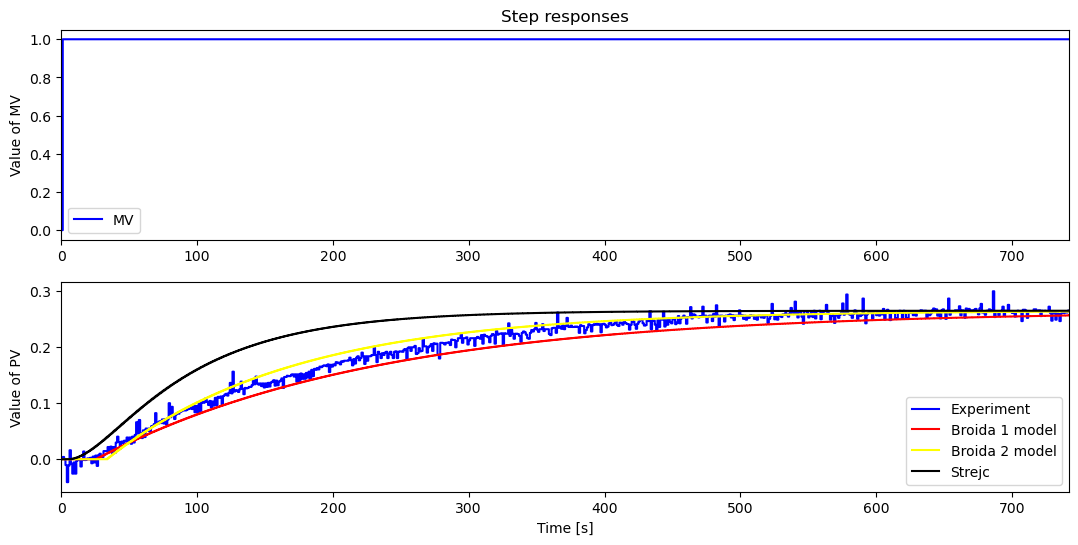

In [22]:
PV_FOPDTOPT = FOPDT(MVm,Kp,T_g,theta_FOPDTOPT,Ts)
PV_FOPDTOPT2 = FOPDT(MVm,Kp,T_g2,theta_FOPDTOPT2,Ts)
Strejc = SOPDT(MVm,Kp,T,Tuth,theta_SOPDTOPT,Ts) #Tuth pas sûr
#PV_SOPDTOPT = SOPDT(MVm,Kp,T1,T2,theta,Ts)

plt.figure(figsize = (13,6))

plt.subplot(2,1,1)
plt.step(tm,MVm,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('Step responses')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'blue',label='Experiment',where='post')
plt.step(tm,PV_FOPDTOPT,'red',label='Broida 1 model',where='post')
plt.step(tm,PV_FOPDTOPT2,'yellow',label='Broida 2 model',where='post')
plt.step(tm,Strejc,'black',label='Strejc',where='post')
#plt.step(tm,PV_SOPDTOPT,'g-',label='Van der Grinten model',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')  
plt.xlim([0, np.max(tm)])
  

### Bode

Text(0, 0.5, 'Phase [°]')

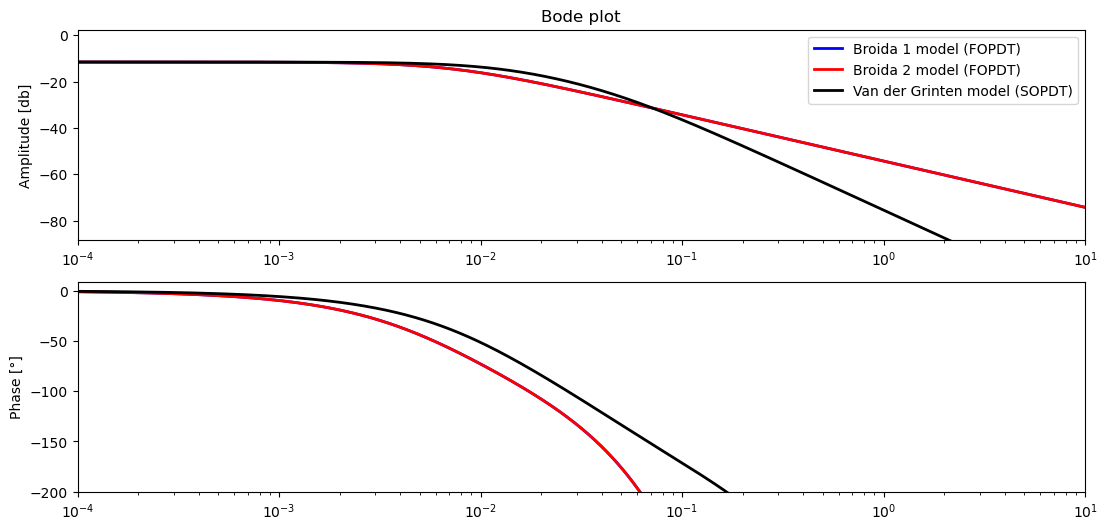

In [23]:
# Frequency response
P_FOPDTOPT = Process({})
P_FOPDTOPT.parameters['Kp'] = Kp
P_FOPDTOPT.parameters['Tlag1'] = T_g
P_FOPDTOPT.parameters['theta'] = theta_FOPDTOPT

# Frequency response
P_FOPDTOPT = Process({})
P_FOPDTOPT.parameters['Kp'] = Kp
P_FOPDTOPT.parameters['Tlag1'] = T_g2
P_FOPDTOPT.parameters['theta'] = theta_FOPDTOPT2

# Frequency response
P_SOPDTOPT = Process({})
P_SOPDTOPT.parameters['Kp'] = Kp
P_SOPDTOPT.parameters['Tlag1'] = T
P_SOPDTOPT.parameters['Tlag2'] = Tuth
P_SOPDTOPT.parameters['theta'] = theta_SOPDTOPT

omega = np.logspace(-4, 1, 10000)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) #Broida 1 (FOPDT)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) #Broida 2 (FOPDT)
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,False) #Van der Grinten model (SOPDT)

plt.figure(figsize = (13,6))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_FOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_FOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'blue',linewidth=2,label='Broida 1 model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'red',linewidth=2,label='Broida 2 model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'black',linewidth=2,label='Van der Grinten model (SOPDT)')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'blue',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'red',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'black',linewidth=2)
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')